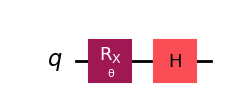

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from gymnasium.spaces import Box
from rl_qoc import (CustomPPO,
                    ContextAwareQuantumEnvironment,
                    RescaleAndClipAction,
                    QiskitConfig,
                    GateTargetConfig, QEnvConfig,
                    ExecutionConfig,
                    )
                    

θ = Parameter('θ')
qc = QuantumCircuit(1)
qc.rx(θ, 0)
qc.h(0)

qc.draw('mpl')

In [2]:
θ_val = np.pi

In [3]:
from qiskit_aer.noise import NoiseModel,coherent_unitary_error
from qiskit.circuit.library import RXGate
γ = 0.01
noisy_unitary = RXGate(γ*θ_val).to_matrix()
noise_model = NoiseModel(basis_gates=["h", "rx", "rz", "t", "s", "sdg", "tdg", "u"])
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(noisy_unitary), 'rx')

In [4]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
backend = GenericBackendV2(1, ["h", "rx", "rz", "t", "s", "sdg", "tdg", "u", 'reset'],
                           calibrate_instructions=True)
backend = AerSimulator.from_backend(backend, noise_model=noise_model)

In [5]:
# Define target gate
target = GateTargetConfig(physical_qubits=[0],
                          gate='h')


In [6]:
# Define parametrized circuit

def apply_parametrized_circuit(qc: QuantumCircuit, params, q_reg, **kwargs):
    my_qc = qc.copy_empty_like(name="h_cal")
    optimal_params = [np.pi/2, 0., np.pi]
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]
    my_qc.u(*new_params, q_reg[0])
    
    qc.append(my_qc.to_gate(label=my_qc.name), q_reg)

qiskit_config = QiskitConfig(apply_parametrized_circuit,
                             backend,
                             parametrized_circuit_kwargs={"target": target, "backend": backend})

In [97]:
# Define the quantum environment
action_space = Box(low=-0.5, high=0.5, shape=(3,), dtype=np.float32)
env_metadata = {"γ": γ,
                "θ": θ_val}
training_config = QEnvConfig(target=target,
                             backend_config=qiskit_config,
                             reward_config='channel',
                             execution_config=ExecutionConfig(batch_size=32,
                                                              sampling_paulis=100,
                                                              n_shots=10000,
                                                              n_reps=9
                                                              ),
                             action_space=action_space,
                             env_metadata= env_metadata
                             )

In [98]:
q_env = ContextAwareQuantumEnvironment(training_config, 
                                       circuit_context=qc.assign_parameters({θ: θ_val}))
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

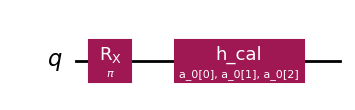

In [99]:
q_env.circuits[0].draw('mpl')

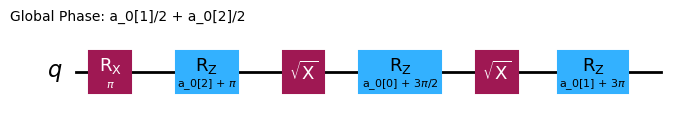

In [100]:
from qiskit import transpile
transpile(q_env.circuits[0], basis_gates=["ry", "rz", 'sx', 'rx']).draw('mpl')

In [101]:
from rl_qoc.agent import PPOConfig

ppo_config = PPOConfig.from_yaml("agent_config.yaml")


In [102]:
from rl_qoc.agent import TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(ppo_config, rescaled_env, save_data=False)

In [103]:
total_updates = 300
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

run_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [104]:
print(q_env.backend.target)

Target: Generic Target with 1 qubits
Number of qubits: 1
Instructions:
	h
		(0,):
			Duration: 5.5278e-08 sec.
			Error Rate: 9.65894e-05
			With pulse schedule calibration
	rx
		(0,):
			Duration: 3.0192e-08 sec.
			Error Rate: 9.05539e-05
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 5.0394e-08 sec.
			Error Rate: 9.35779e-05
			With pulse schedule calibration
	s
		(0,):
			Duration: 4.7952e-08 sec.
			Error Rate: 9.80724e-05
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 4.6176e-08 sec.
			Error Rate: 9.18653e-05
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 5.7498e-08 sec.
			Error Rate: 9.85689e-05
			With pulse schedule calibration
	u
		(0,):
			Duration: 4.0626e-08 sec.
			Error Rate: 9.92368e-05
			With pulse schedule calibration
	reset
		(0,):
	delay
		(0,):
	measure
		(0,):
			Duration: 1.1231e-06 sec.
			Error Rate: 0.004302
			With pulse schedule cal

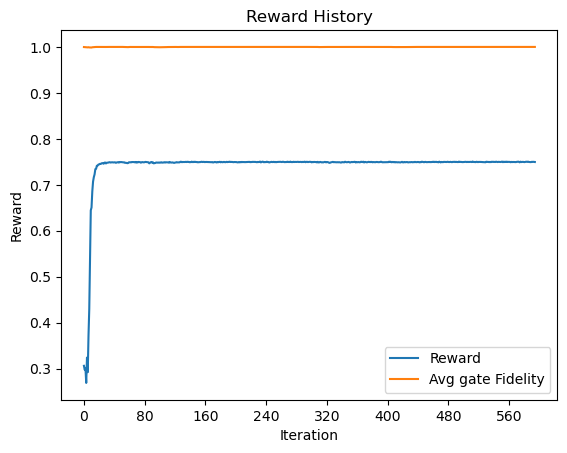


 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999976764909236
Hardware runtime taken: 532.2472661634896 min  14.835969809373637 seconds
Sending Estimator job...
Time for running 0.027660846710205078
Finished Estimator job
Reward (avg): 0.7495320836814348 Std: 0.0015962209493652682

 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999970827772618
Hardware runtime taken: 533.1200663768229 min  7.203982609375089 seconds
Sending Estimator job...
Time for running 0.02772974967956543
Finished Estimator job
Reward (avg): 0.7498487798359659 Std: 0.001614550187734688

 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9999965715131042
Hardware runtime taken: 533.9928665901563 min  59.57199540937654 seconds
Sending Estimator job...
Time for running 0.02745199203491211
Finished Estimator job
Reward (avg): 0.7497852797661717 

{'avg_reward': [0.3062342086190777,
  0.29768753169509554,
  0.3008880860893076,
  0.26902177154405715,
  0.3241221020988705,
  0.2923723910296602,
  0.37175127128757596,
  0.4299946572986336,
  0.5351598621797717,
  0.6444492041062961,
  0.6507646863352183,
  0.6857369860670313,
  0.7070114344933962,
  0.7166031722382865,
  0.7227293382008162,
  0.7340863109165314,
  0.7349477598278698,
  0.7414029413325449,
  0.7418452269326145,
  0.744044120812525,
  0.7444574302305293,
  0.7456327321540193,
  0.7453515793772945,
  0.7462212799405178,
  0.7473027224741883,
  0.7469188190430662,
  0.745922869758249,
  0.7481523936758254,
  0.7484779050941638,
  0.7464791861251485,
  0.7480827365182738,
  0.7481261353844881,
  0.748330648258174,
  0.7489750884258779,
  0.7491882710403353,
  0.7484847229342422,
  0.7488563507183603,
  0.7490581741976032,
  0.7489270185376988,
  0.7486403245568201,
  0.7489338254968156,
  0.7488544077518411,
  0.7478583825701844,
  0.7484620671674722,
  0.74901231364219

<Figure size 640x480 with 0 Axes>

In [114]:
ppo_agent.train(run_config, train_settings)

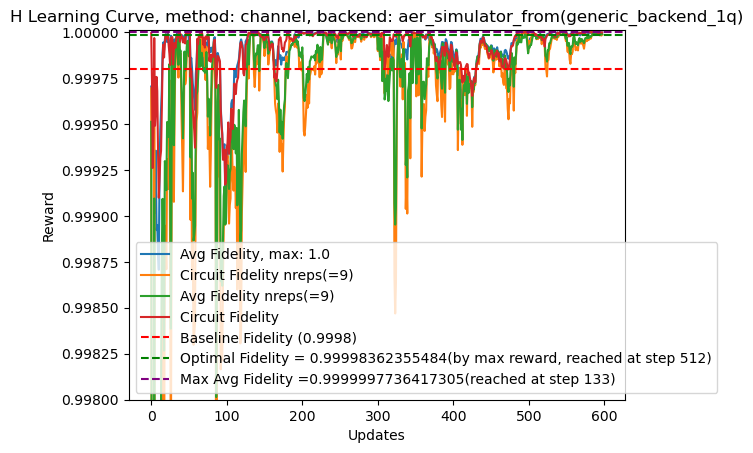

In [115]:
# Plotting the learning curve
import matplotlib.pyplot as plt
reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(q_env.simulate_circuit(q_env.circuits[0], np.zeros((1, 3)), update_env_history=False), 4)[0]

plot_reward = False
plot_fidelity = True
plot_circuit_fidelity = True
plot_fidelity_nreps = True
plot_circuit_fidelity_nreps = True

if plot_reward:
    plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
if plot_fidelity:
    plt.plot(
        q_env.fidelity_history,
        label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
    )
if plot_circuit_fidelity_nreps:
    plt.plot(
        q_env.circuit_fidelity_history_nreps,
        label=f"Circuit Fidelity nreps(={q_env.n_reps})",
    )
if plot_fidelity_nreps:
    plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
if plot_circuit_fidelity:
    plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity = {q_env.fidelity_history[arg_max_mean]}(by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity ={np.max(q_env.fidelity_history)}(reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
)
plt.ylim(0.998, 1.00001)
plt.legend()

In [116]:
q_env.optimal_action

array([ 0.00083911, -0.04055472, -0.00375056], dtype=float32)

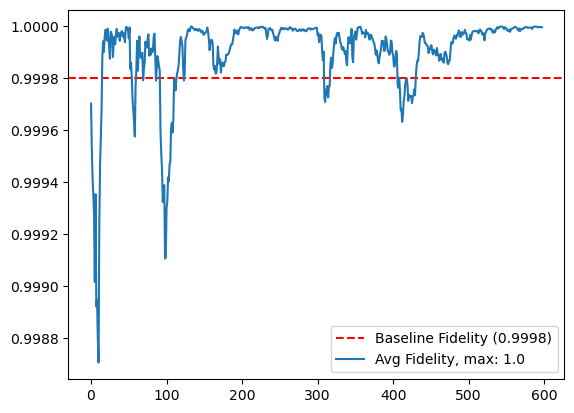

In [117]:
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.plot(
    q_env.fidelity_history,
    label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
)
plt.legend()